In [9]:
import nltk,re,time,umap,collections,os,string,sys,mlflow
sys.path.append(os.path.abspath(".."))
from modules import utils,modeling

from sentence_transformers import SentenceTransformer
import plotly.express as px
import pandas as pd

from sklearn.metrics import completeness_score,homogeneity_score, v_measure_score,normalized_mutual_info_score,adjusted_mutual_info_score,silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


from hdbscan import HDBSCAN
from sentence_transformers import models
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer
from torch import nn
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from sklearn.preprocessing import StandardScaler

remote_server="http://ec2-18-193-70-141.eu-central-1.compute.amazonaws.com"
client = MlflowClient(remote_server)
mlflow.set_tracking_uri(remote_server)

#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")


%matplotlib inline
%load_ext autoreload
%autoreload 2

%reload_ext utils
%reload_ext modeling
os.environ["MLFLOW_S3_ENDPOINT_URL"]="http://s3.eu-central-1.amazonaws.com"
os.environ["MLFLOW_TRACKING_USERNAME"]="mlflow"
os.environ["MLFLOW_TRACKING_PASSWORD"]="mlflow"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
X = utils.load_labeled_data()
y= X["labels"]
X.drop(["labels","site","entities_analyzed","updated_at"],inplace=True,axis="columns")
y_summarized_clusters = dict(collections.Counter(y))

X.head(1)

,headline,text,seo_title,created_at_date,created_at
article_uid,,,,,
5ed1398149006b863542719239e660f51f2bfb43eae5954d5a26b0596cbb54ae,US Open: Als Alexander Zverev seinen Eltern da...,Was für ein Drama! Was für Emotionen! Alexande...,"Als er seinen Eltern dankte, kamen ihm die Tränen",9/14/20,2020-09-14 11:56:15


(239, 9)


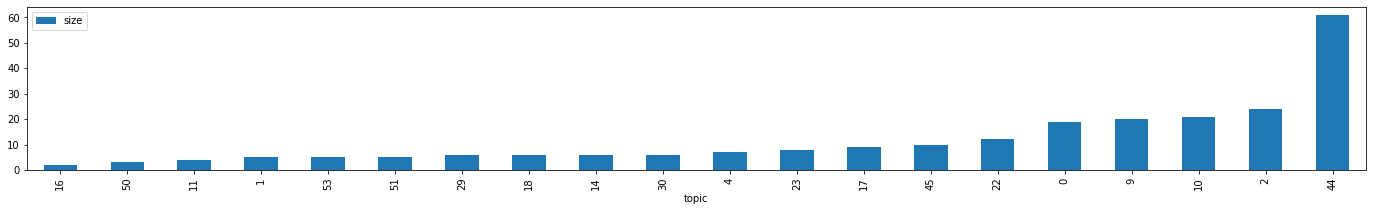

In [4]:
X = utils.load_labeled_data()
print(X.shape)
pd.DataFrame(y_summarized_clusters.items(),columns=["topic",'size']).set_index("topic").sort_values("size").plot(kind="bar",figsize=(24,3))


In [7]:
#experiments = client.list_experiments() # returns a list of mlflow.entities.Experiment
mlflow.set_experiment("eval-bert-german-dbmdz-uncased-sentence-stsb")


word_embedding_model = models.Transformer('T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb',max_seq_length=512)
__X =X.copy()
__X["text"] =__X['seo_title'].apply(lambda x: utils.remove_seo_title_marker(x,True))+". "+__X["text"] 
pdf = utils.preprocess_articles_for_bert(__X,"text")

X['mix'] =  X['headline'].apply(str.lower) +" "+ X["seo_title"].apply(utils.remove_seo_title_marker) #+ df["text"].apply(lambda x: " ".join(x.split(" ")[:150]))
X["mix"]=X["mix"].apply(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
X['mix']

article_uid
5ed1398149006b863542719239e660f51f2bfb43eae5954d5a26b0596cbb54ae    us open als alexander zverev seinen eltern dan...
f59166e70933714ac41d44a70ace1fe014dd59d957cfb3bdddf873d7561819fd    reaktionen auf zverevs tenniskrimi „kopf hoch ...
5b5e70d73984da9cda4fb1606282e623b6f7c2cd7a7265cbde7bd11572c6474a    alexander zverev us open – titeltraum zerstört...
922875e67c48b975a8a9f36c623f2ec118d25ae2389d0e326c7827b7f5e91fa5    tennis alexander zverev – bruder mischa kommen...
190308d386d6b939c531f927c6d7b596c153b70cec95289988408770256912a6    us open alex zverev gegen dominic thiem – freu...
                                                                                          ...                        
ae9a4a5b99be78378d6c4708c442c38e8a618a73e2fbc1417557c7f8d312a018    „love island“ sexy poledanceaction in der show...
94a42d1d85cda20adfcc0dba552969817dbf5433c477366ef0761a271a1a8dea    „festspiele der reality stars“ micaela schäfer...
b29bb3863c32aa99f4029e1f07404aa98e0b19f699a6

In [8]:

max_pooling = False

embeddings = modeling.get_sentence_embeddings(pdf,word_embedding_model,max_pooling)

mlflow.end_run()


--- Embedding dimension 768
--- 239 Documnets encoded 104.96177101135254 seconds ---


## MLflow Expriement for unfitted UMAP and HDBSCAN


In [ ]:
alpha=0.85
_embeddings = StandardScaler().fit_transform(embeddings)

levels = [ [128,196,256,384],
          [embeddings,_embeddings],
         np.arange(0.1,.6,0.05),
          range(2, 5),range(2, 5),[4,6,8,10,12]
          
         ]
ctr=0
total_iter = np.array([len(l) for l in levels]).prod()
for N_COMPONENTS in levels[0]:
    for ix_emb,emb in enumerate(levels[1]):
        for epsilion in levels[2]:  
            for min_cluster_size in levels[3]:
                for min_samples in levels[4]:        
                    for n_neighbors in levels[5]:
                        print("{}/{}".format(ctr,total_iter))
                        with mlflow.start_run():
                            #word_embedding_model.encode("pdf")
                            mlflow.log_param("Emebddings_normalized",bool(ix_emb))
                            mlflow.set_tag("Feature column","headline+text_low_processed")
                            #ctr=0
                            mlflow.log_param(key="max_pooling",value=max_pooling)
                            mlflow.log_param(key="min_cluster_size",value=min_cluster_size)
                            mlflow.log_param(key="N_COMPONENTS",value=N_COMPONENTS)
                            mlflow.log_param(key="cluster_selection_epsilon",value=epsilion)
                            mlflow.log_param(key="min_samples",value=min_samples)
                            mlflow.log_param(key="alpha",value=alpha)

                            mlflow.log_param(key="n_neighbors",value=n_neighbors)
                            results,cluster_labels = modeling.cluster_and_reduce(emb,n_components_clustering=N_COMPONENTS,
                                                                                 min_cluster_size=min_cluster_size,n_neighbors=n_neighbors, 
                                                                                 min_samples= min_samples,alpha=alpha,cluster_selection_epsilon=float(epsilion))
                            mlflow.log_metric(key="completeness_score", value=completeness_score(cluster_labels,y.values))
                            mlflow.log_metric(key="v_measure_score", value=v_measure_score(cluster_labels,y.values))
                            mlflow.log_metric(key="homogeneity_score", value=homogeneity_score(cluster_labels,y.values))
                            mlflow.log_metric(key="normalized_mutual_info_score", value=v_measure_score(cluster_labels,y.values))

                            summarized_clusters = dict(collections.Counter(cluster_labels))
                            try:
                                mlflow.log_metric(key="outliers_ratio", value=(summarized_clusters[-1]/len(cluster_labels)))
                            except Exception as err:
                                mlflow.log_metric(key="outliers_ratio", value=0)

                            mlflow.log_metric(key="unique_cluters", value=len(summarized_clusters.items()))
                            mlflow.log_metric(key="clusters_ratio_to_GT", value=(len(summarized_clusters.items())-1)/len(y_summarized_clusters.items()))
                            mlflow.log_metric(key="silhuette_score", value=silhouette_score(emb,cluster_labels))

                            results = utils.link_to_raw_data(results,X,cluster_labels)
                            if len(summarized_clusters.items()) < 25 and len(summarized_clusters.items()) > 15:
                                try:
                                    modeling.scatter_plot(results,save_fig=True)
                                    mlflow.log_artifact("./tmp_scatter_plot.html")
                                except Exception as err:
                                    print(err)
                        
                        ctr+=1




In [ ]:
results,cluster_labels = modeling.cluster_and_reduce(embeddings,n_components_clustering=32,
                                                     min_cluster_size=2, min_samples= 3,alpha= 1.0)
completeness_score(cluster_labels,y.values), v_measure_score(cluster_labels,y.values)

In [ ]:
cluster_labels

In [ ]:
def mlflow_run_model_eval(mlflow,embeddings,df,**kwargs):
    with mlflow.start_run():

        #mlflow.log_params(kwargs)

        results,cluster_labels = modeling.c(embeddings,n_components_clustering=N_COMPONENTS,
                                                             min_cluster_size=min_cluster_size,n_neighbors=n_neighbors, 
                                                             min_samples= min_samples,alpha=alpha)
        mlflow.log_metric(key="completeness_score", value=completeness_score(cluster_labels,y.values))
        mlflow.log_metric(key="v_measure_score", value=v_measure_score(cluster_labels,y.values))
        mlflow.log_metric(key="homogeneity_score", value=homogeneity_score(cluster_labels,y.values))
        mlflow.log_metric(key="normalized_mutual_info_score", value=v_measure_score(cluster_labels,y.values))

        summarized_clusters = dict(collections.Counter(cluster_labels))
        try:
            mlflow.log_metric(key="outliers_ratio", value=(summarized_clusters[-1]/len(cluster_labels)))
        except Exception as err:
            mlflow.log_metric(key="outliers_ratio", value=0)

        mlflow.log_metric(key="unique_cluters", value=len(summarized_clusters.items()))
        mlflow.log_metric(key="cluters_ratio_to_GT", value=(len(summarized_clusters.items())-1)/len(y_summarized_clusters.items()))
        #mlflow.log_metric(key="silhuette_score", value=silhouette_score(_X,cluster_labels))

        results = utils.link_to_raw_data(results,df,cluster_labels)

        modeling.scatter_plot(results,save_fig=True)
        mlflow.log_artifact("./tmp_scatter_plot.html")
    

In [12]:
X = utils.load_labeled_data()
X.drop(["site","entities_analyzed","updated_at"],inplace=True,axis="columns")
y_summarized_clusters = dict(collections.Counter(y))

X.head(1)

,labels,headline,seo_title,text,created_at_date,created_at
article_uid,,,,,,
5ed1398149006b863542719239e660f51f2bfb43eae5954d5a26b0596cbb54ae,0,US Open: Als Alexander Zverev seinen Eltern da...,"Als er seinen Eltern dankte, kamen ihm die Tränen",Was für ein Drama! Was für Emotionen! Alexande...,9/14/20,2020-09-14 11:56:15


,labels,headline,seo_title,text,created_at_date,created_at
article_uid,,,,,,
5ed1398149006b863542719239e660f51f2bfb43eae5954d5a26b0596cbb54ae,0,US Open: Als Alexander Zverev seinen Eltern da...,"Als er seinen Eltern dankte, kamen ihm die Tränen",Was für ein Drama! Was für Emotionen! Alexande...,9/14/20,2020-09-14 11:56:15
f59166e70933714ac41d44a70ace1fe014dd59d957cfb3bdddf873d7561819fd,0,Reaktionen auf Zverevs Tennis-Krimi: „Kopf hoc...,"„Kopf hoch, mein Junge - du kommst zurück!“",Was für ein Match. Nach dem Fünf-Satz-Krimi (6...,9/14/20,2020-09-14 05:03:15
5b5e70d73984da9cda4fb1606282e623b6f7c2cd7a7265cbde7bd11572c6474a,0,Alexander Zverev: US Open – Titeltraum zerstör...,Zverevs Titel-Traum zerstört,Er war so nah dran am ganz großen Triumph ... ...,9/14/20,2020-09-14 02:27:15
922875e67c48b975a8a9f36c623f2ec118d25ae2389d0e326c7827b7f5e91fa5,0,Tennis: Alexander Zverev – Bruder Mischa komme...,Im TV! Zverevs Bruderkommen die Tränen,Große Gefühle vorm großen Finale! Kurz vor dem...,9/13/20,2020-09-13 22:33:15
190308d386d6b939c531f927c6d7b596c153b70cec95289988408770256912a6,0,US Open: Alex Zverev gegen Dominic Thiem – Fre...,Thiem gegen Zverev –das Kumpel-Duell!,Jagd auf die Titel-Premiere! Wenn Alexander „S...,9/13/20,2020-09-13 17:07:16
...,...,...,...,...,...,...
ae9a4a5b99be78378d6c4708c442c38e8a618a73e2fbc1417557c7f8d312a018,45,„Love Island“: Sexy Poledance-Action in der Sh...,Heiße Poledance-Einlage inder „Love Island“-Villa,Ab an die Stange! Eine Poledance-Einlage über...,9/11/20,2020-09-11 16:49:15
94a42d1d85cda20adfcc0dba552969817dbf5433c477366ef0761a271a1a8dea,45,„Festspiele der Reality Stars“: Micaela Schäfe...,Micaela (36) ist scharf auf Gerhard Schröder (76),Dieses Lippenbekenntnis konnte keiner richtig ...,9/12/20,2020-09-12 10:56:15
b29bb3863c32aa99f4029e1f07404aa98e0b19f699a619de67f0391bf2fcc495,45,„Love Island“: Fummel-Premiere bei Ex-„Bachelo...,Fummel-Premiere auf „Love Island“,Nächster Hormon-Schub im Paradies! Nachdem Min...,9/11/20,2020-09-11 02:26:15


In [129]:
pd.options.plotting.backend = "plotly"


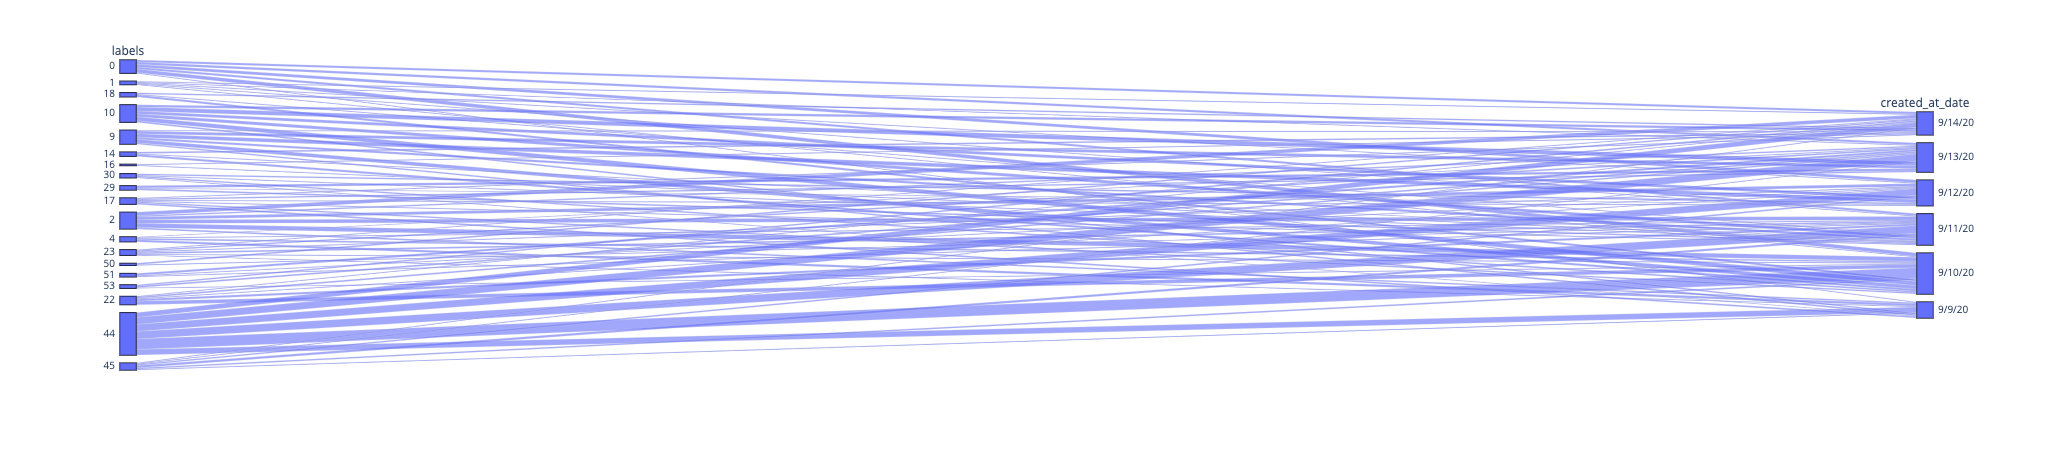

In [106]:
df
fig = px.parallel_categories(X,labels="created_at_date", color_continuous_scale=px.colors.sequential.Inferno)
fig.show()


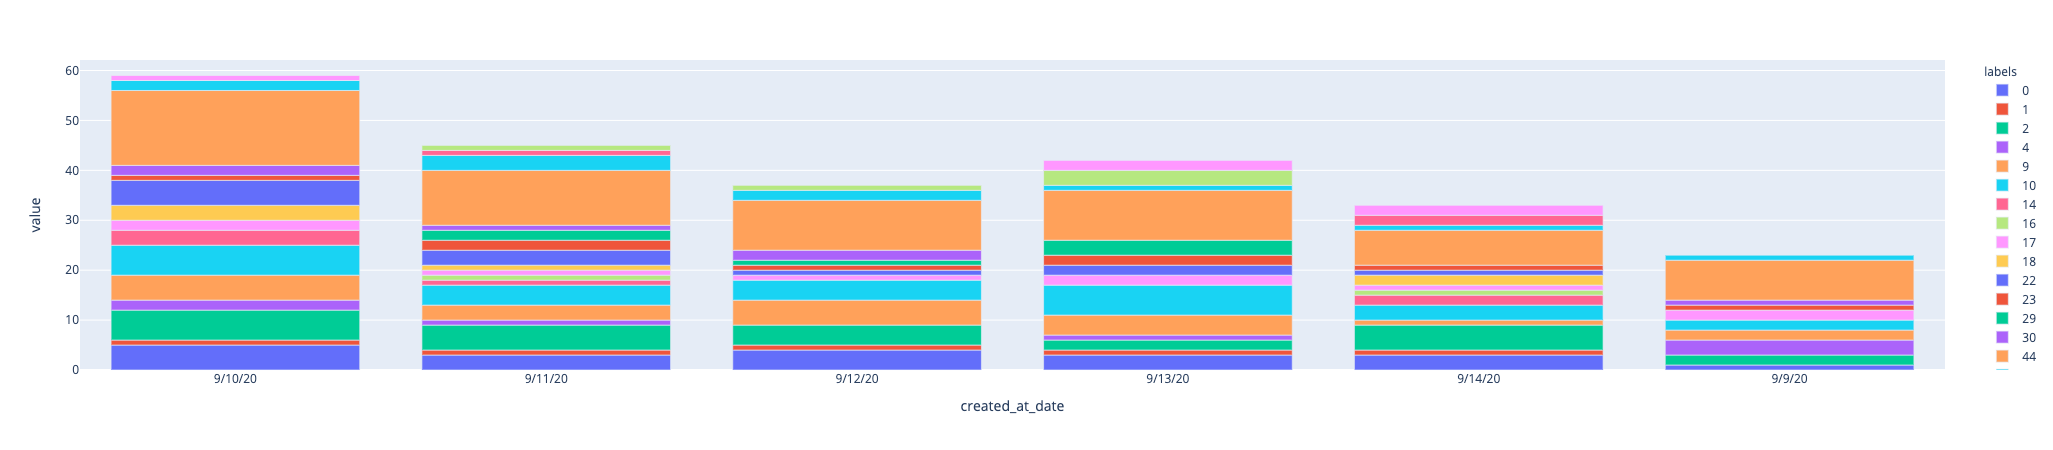

In [134]:
X.groupby(['labels','created_at_date']).count().unstack()["text"].T.plot(kind="bar")

In [99]:
X[['labels',"created_at_date",'headline']].groupby(['labels','created_at_date']).count().unstack()['headline']

created_at_date,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/9/20
labels,,,,,,
0,5.0,3.0,4.0,3.0,3.0,1.0
1,1.0,1.0,1.0,1.0,1.0,NaN
2,6.0,5.0,4.0,2.0,5.0,2.0
4,2.0,1.0,NaN,1.0,NaN,3.0
9,5.0,3.0,5.0,4.0,1.0,2.0
10,6.0,4.0,4.0,6.0,3.0,2.0
14,3.0,1.0,NaN,NaN,2.0,NaN
16,NaN,1.0,NaN,NaN,1.0,NaN
17,2.0,1.0,1.0,2.0,1.0,2.0
